<a href="https://colab.research.google.com/github/Methe11/Book-Recommendation-System/blob/main/Aishwarya_Methe_Copy_of_Book_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import required libraries
import re
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# File path's

In [3]:
# # books file path
books = pd.read_csv('/content/drive/MyDrive/Amazon Book-Recommendation-System/Books.csv')
# # users file path
users = pd.read_csv('/content/drive/MyDrive/Amazon Book-Recommendation-System/Users.csv')
# # ratings file path
ratings = pd.read_csv('/content/drive/MyDrive/Amazon Book-Recommendation-System/Ratings.csv')

# DATA Preprocessing

## Books data cleaning


In [4]:
# look at the books data
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
# info
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [6]:
# columns and data shape
print(f"Books dataset shape : {books.shape}")
print(f"Books columns: {list(books.columns)} " )

Books dataset shape : (271360, 8)
Books columns: ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L'] 


In [7]:
# Drop URL columns that arent required for analysis
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
print(f'Books table after dropping the 3 Image-cols')
books.head()

Books table after dropping the 3 Image-cols


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [8]:
# Checking for null values
col_with_nulls = books.isnull().sum()
col_with_nulls

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
dtype: int64

In [9]:
books.loc[books['Book-Author'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


In [10]:
# return indices of null values
b_null_items = [] 
for col in books.columns:
  b_null_items += books[books[col].isnull()].index.tolist()
print(f'The indices of null values are : {b_null_items}')


The indices of null values are : [187689, 128890, 129037]


In [11]:
# items with missing data 
books.iloc[b_null_items]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [12]:
## Checking for column Year-of-publication
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [13]:
pd.set_option('display.max_colwidth', -1)

In [14]:
# at Year-Of-Publication = DK Publishing Inc
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


In [15]:
# at Year-Of-Publication = Gallimard
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


In [16]:
# well it's not just the years but also author and publisher names have been interchanged
# let's correct this by inserting the right values into them

# change values of book(209538)
books.at[209538 ,'Publisher'] = 'DK Publishing Inc'
books.at[209538 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'Michael Teitelbaum'

# change values of book(221678)
books.at[221678 ,'Publisher'] = 'DK Publishing Inc'
books.at[221678 ,'Year-Of-Publication'] = 2000
books.at[221678 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
books.at[221678 ,'Book-Author'] = 'James Buckley'

# change values of book(220731)
books.at[220731 ,'Publisher'] = 'Gallimard'
books.at[220731 ,'Year-Of-Publication'] = 2003
books.at[220731 ,'Book-Title'] = 'Peuple du ciel - Suivi de Les bergers '
books.at[220731 ,'Book-Author'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'

In [17]:
## Converting year of publication in Numbers
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

In [18]:
# confirming the change
for index in [209538,221678,220731]:
  print(books.iloc[index])
  print('-'*30)

ISBN                   078946697X                                                                    
Book-Title             DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)
Book-Author            Michael Teitelbaum                                                            
Year-Of-Publication    2000                                                                          
Publisher              DK Publishing Inc                                                             
Name: 209538, dtype: object
------------------------------
ISBN                   0789466953                                                                                
Book-Title             DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)
Book-Author            James Buckley                                                                             
Year-Of-Publication    2000                                                              

In [19]:
# convert type to int
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype('int64')

In [20]:
# before cleaning - sorted dates
sorted_book_dates = sorted(list(books['Year-Of-Publication'].unique()))
print(sorted_book_dates)

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


Text(0.5, 1.0, 'Box plot of Year-Of-Publication column before outlier removal')

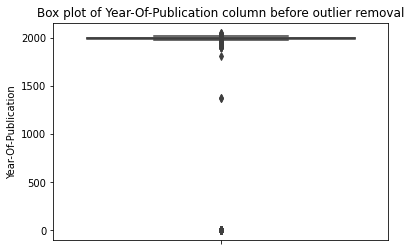

In [21]:
# boxplot before handling outliers 
sns.boxplot(y='Year-Of-Publication', data=books)
plt.title('Box plot of Year-Of-Publication column before outlier removal')

In [22]:
sorted_book_dates[:4]

[0, 1376, 1378, 1806]

In [23]:
# book published during year 0
books.loc[books['Year-Of-Publication']==sorted_book_dates[0]]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
176,3150000335,Kabale Und Liebe,Schiller,0,"Philipp Reclam, Jun Verlag GmbH"
188,342311360X,Die Liebe in Den Zelten,Gabriel Garcia Marquez,0,Deutscher Taschenbuch Verlag (DTV)
288,0571197639,Poisonwood Bible Edition Uk,Barbara Kingsolver,0,Faber Faber Inc
351,3596214629,"Herr Der Fliegen (Fiction, Poetry and Drama)",Golding,0,Fischer Taschenbuch Verlag GmbH
542,8845229041,Biblioteca Universale Rizzoli: Sulla Sponda Del Fiume Piedra,P Coelho,0,Fabbri - RCS Libri
...,...,...,...,...,...
270794,014029953X,Foe (Essential.penguin S.),J.M. Coetzee,0,Penguin Books Ltd
270913,0340571187,Postmens House,Maggie Hemingway,0,Trafalgar Square
271094,8427201079,El Misterio De Sittaford,Agatha Christie,0,Editorial Molino
271182,0887781721,Tom Penny,Tony German,0,P. Martin Associates


In [24]:
# book published in 1376
books.loc[books['Year-Of-Publication']==sorted_book_dates[1]]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
253750,964442011X,Tasht-i khun,IsmaÂ°il Fasih,1376,Nashr-i Alburz


In [25]:
books.loc[books['Year-Of-Publication']==sorted_book_dates[2]]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
227531,9643112136,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378,Intisharat-i Quqnus


In [26]:
# correcting years of books in dataset

# book - Tasht-i khun
books.loc[books['Year-Of-Publication']==sorted_book_dates[1], 'Year-Of-Publication'] = 1996
# book - Dalan-i bihisht (Dastan-i Irani)
books.loc[books['Year-Of-Publication']==sorted_book_dates[2], 'Year-Of-Publication'] = 1999

# replace the null and outliers with the mode(year-of-publication)
books.loc[(books['Year-Of-Publication'] > 2004) , 'Year-Of-Publication'] = 2002
books.loc[(books['Year-Of-Publication'] == 0), 'Year-Of-Publication'] = 2002

In [27]:
# after cleaning - sorted dates
print(sorted(list(books['Year-Of-Publication'].unique())))

[1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004]


Text(0.5, 1.0, 'Box plot of Year-Of-Publication column after removing outliers')

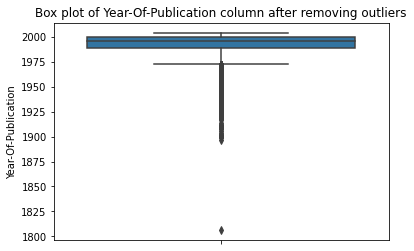

In [28]:
# boxplot before handling outliers 
sns.boxplot(y='Year-Of-Publication', data=books)
plt.title('Box plot of Year-Of-Publication column after removing outliers')

In [31]:
# Upper casing all alphabets in ISBN
books['ISBN'] = books['ISBN'].str.upper()

In [32]:
# Drop duplicate rows
books.drop_duplicates(keep='last', inplace=True) 
books.reset_index(drop = True, inplace = True)

# size of df after dropping
print(f'Shape of dataframe after dropping duplicates : {books.shape}')
print(f'Number of duplicates dropped are : {271361 - books.shape[0]}')

Shape of dataframe after dropping duplicates : (271047, 5)
Number of duplicates dropped are : 314


In [33]:
# checking ISBN for special charecters
def specialCharDetector(d_frame,col_v):
  flag = 0
  reg = "[^A-Za-z0-9]"

  # loop through each item(isbn) in the given col
  for x in d_frame[col_v]:
      z = re.search(reg,x)    
      if z:
          flag = 1
  # if flag is set to 1 then there are special charecters
  if flag == 1:
      print(f" Special charecters found in {col_v}")
  else:
      print(f" No special charecters found in {col_v}")

In [34]:
specialCharDetector(books,'ISBN')

 Special charecters found in ISBN


In [35]:
# removing extra characters from ISBN (from ratings dataset) existing in books dataset
def removeSpecialChar(df_):
  bookISBN = df_['ISBN'].tolist() 
  reg = "[^A-Za-z0-9]" 
  for index, row_Value in df_.iterrows():
      z = re.search(reg, row_Value['ISBN'])    
      if z:
          f = re.sub(reg,"",row_Value['ISBN'])
          if f in bookISBN:
              df_.at[index , 'ISBN'] = f

In [36]:
# remove special charecters
# removeSpecialChar(books)

In [37]:
# count plot values on required axis based off  on the dataframe
def CountPlotN(col,data,n,title,axis_flag=0):
  
  ''' count plot values on required axis
  axis_flag - specify axis-(0)=y_axis ; (1)=x_axis, 
  data - dataframe,
  n - select the topN values to be displaced
  title - specify the title to be displayed '''

  plt.figure(figsize=(15,7))
  order = pd.value_counts(data[col]).iloc[:n].index
  # change axis based on flag
  if axis_flag:
    sns.countplot(x=col,data=data,order=order,palette='Paired')
  else:
    sns.countplot(y=col,data=data,order=order,palette='Paired')
  plt.title(title)

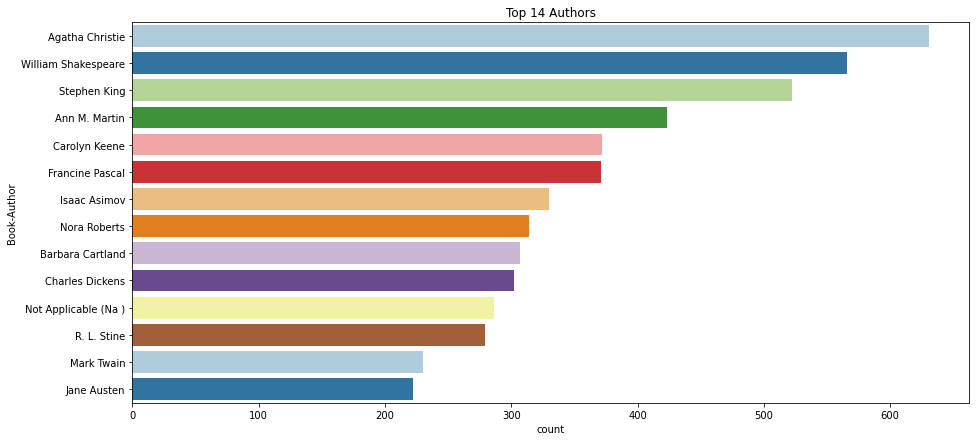

In [38]:
# plot the author whose books were read the most
CountPlotN('Book-Author',books,14,'Top 14 Authors')

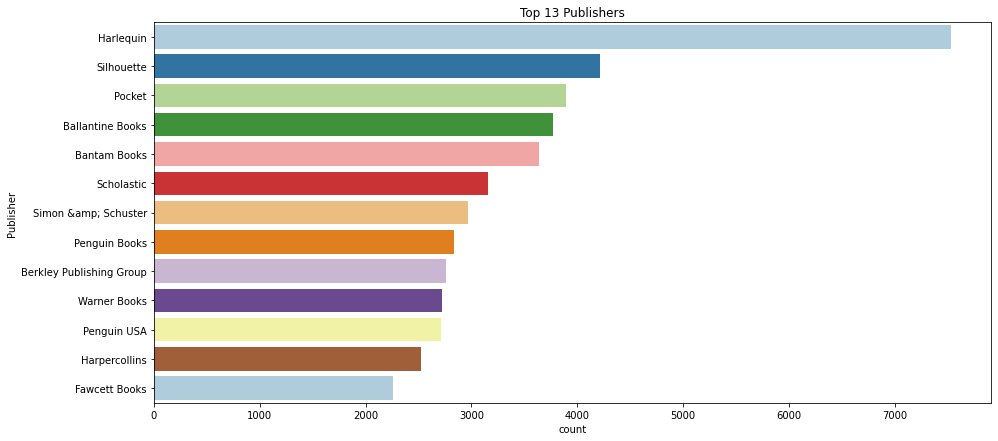

In [39]:
# publishers whoose books were read by the most readers
CountPlotN('Publisher',books,13,'Top 13 Publishers')

Users data cleaning

In [40]:
# look at the users
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [41]:
# info
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [42]:
print(f" Users dataset shape: {users.shape}")
print(f" Columns of users dataset : {list(users.columns)}")

 Users dataset shape: (278858, 3)
 Columns of users dataset : ['User-ID', 'Location', 'Age']


In [43]:
# Checking for null values
print(users.isna().sum())

User-ID     0     
Location    0     
Age         110762
dtype: int64


In [44]:
# Check for all unique values present in Age column
print(sorted(list(users['Age'].unique())))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

Text(0.5, 1.0, 'Distribution Plot of users age ')

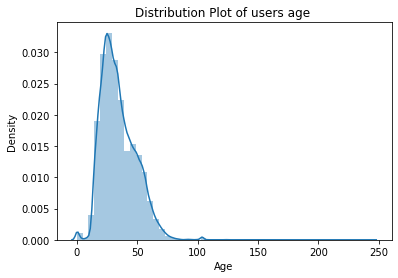

In [45]:
# Dist Plot of users age
sns.distplot(users.Age)
plt.title('Distribution Plot of users age ')

In [46]:
# CountPlotN('Age',users,len(users),'bal',1)

From the above list we can see that there are outliers in the dataset(age)

Text(0.5, 1.0, 'Box plot of Age column before outlier removal')

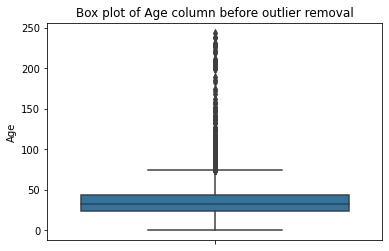

In [47]:
# boxplot before handling outliers 
sns.boxplot(y='Age', data=users)
plt.title('Box plot of Age column before outlier removal')

In [48]:
# claclulate the mean users age 
mean_user_age = round( users[(users['Age'] <= 90) & (users['Age'] >= 10)]['Age'].mean())
mean_user_age

35

In [49]:
# outliers with age grater than 80 & age less than 10 years are substitued with mean users age
users.loc[(users['Age'] > 90) | (users['Age'] < 10 ), 'Age'] = mean_user_age
# filling null values with mean
users['Age'] = users['Age'].fillna(mean_user_age)     
# finally changing Datatype to int
users['Age'] = users['Age'].astype(int)

In [50]:
# double check to see if missing values are present
users['Age'].isna().sum()

0

Text(0.5, 1.0, 'Distribution Plot of users age after mean replacement')

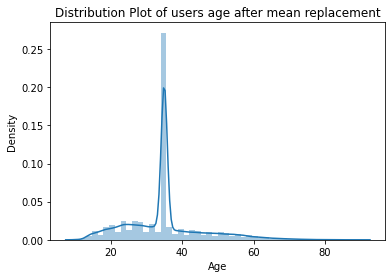

In [51]:
# Dist Plot of users age after fillings missing values and treating outliers
sns.distplot(users.Age)
plt.title('Distribution Plot of users age after mean replacement')

Text(0.5, 1.0, 'Box plot of Age column after removing outliers')

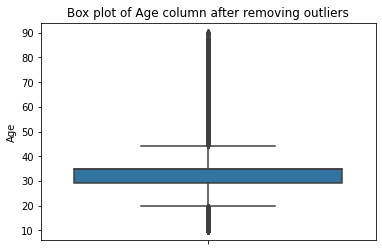

In [52]:
# boxplot after handling outliers 
sns.boxplot(y='Age', data=users)
plt.title('Box plot of Age column after removing outliers')

In [53]:
# CountPlotN('Age',users,len(users),'bal',1)

Well we have successfully handled the removal of all the existing null values in the age column

In [54]:
# in the dataset allthe city-state-country are gropued together 
# the code below will help split these into their respective categorys and add them into the df as cols

# split users location
list_ = users.Location.str.split(', ')

# lists of city,state & country
city = []
state = []
country = []
count_no_state = 0    
count_no_country = 0

# remove invalid entries too
for i in range(0,len(list_)):
    if list_[i][0] == ' ' or list_[i][0] == '' or list_[i][0]=='n/a' or list_[i][0] == ',':  
        city.append('other')
    else:
        city.append(list_[i][0].lower())

    if(len(list_[i])<2):
        state.append('other')
        country.append('other')
        count_no_state += 1
        count_no_country += 1
    else:
        if list_[i][1] == ' ' or list_[i][1] == '' or list_[i][1]=='n/a' or list_[i][1] == ',': 
            state.append('other')
            count_no_state += 1            
        else:
            state.append(list_[i][1].lower())
        
        if(len(list_[i])<3):
            country.append('other')
            count_no_country += 1
        else:
            if list_[i][2] == ''or list_[i][1] == ',' or list_[i][2] == ' ' or list_[i][2] == 'n/a':
                country.append('other')
                count_no_country += 1
            else:
                country.append(list_[i][2].lower())

# drop the locations col
users = users.drop('Location',axis=1)

temp = []
for ent in city:
    # handling cases where city/state entries from city list as state is already given 
    c = ent.split('/')            
    temp.append(c[0])

# create respective dataframes
df_city = pd.DataFrame(temp,columns=['City'])
df_state = pd.DataFrame(state,columns=['State'])
df_country = pd.DataFrame(country,columns=['Country'])

# add these newly created df to users df
users = pd.concat([users, df_city], axis=1)
users = pd.concat([users, df_state], axis=1)
users = pd.concat([users, df_country], axis=1)

# printing the number of countries didnt have any values 
print(count_no_country) 
# printing the states which didnt have any   
print(count_no_state)

4659
16044


In [55]:
# Drop duplicate rows
users.drop_duplicates(keep='last', inplace=True)
users.reset_index(drop=True, inplace=True)

# size of df after dropping
print(f'Shape of dataframe after dropping duplicates : {users.shape}')
print(f'Number of duplicates dropped are : {278858 - users.shape[0]}')

Shape of dataframe after dropping duplicates : (278858, 5)
Number of duplicates dropped are : 0


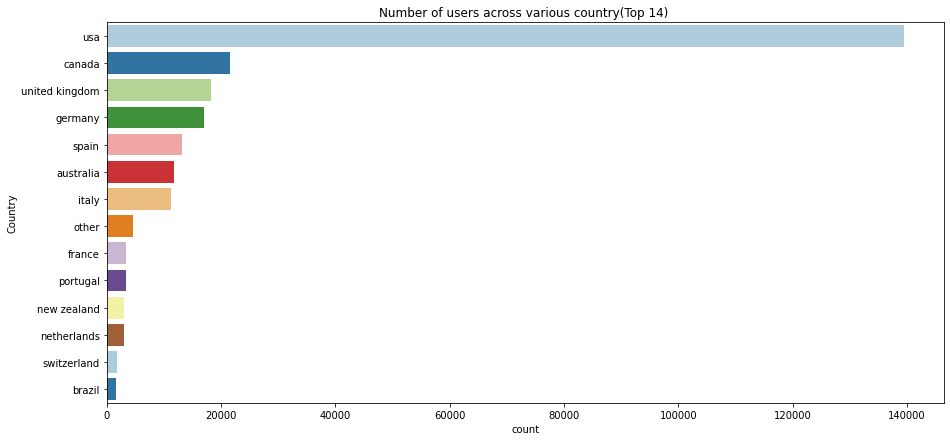

In [56]:
# readers across various countries
CountPlotN('Country',users,14,'Number of users across various country(Top 14) ')

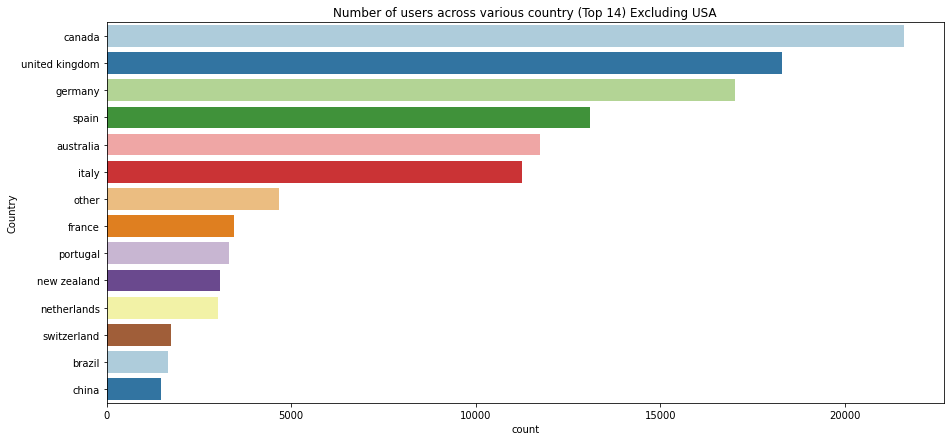

In [57]:
# excluding USA
CountPlotN('Country',users[users['Country']!='usa'],14,'Number of users across various country (Top 14) Excluding USA')

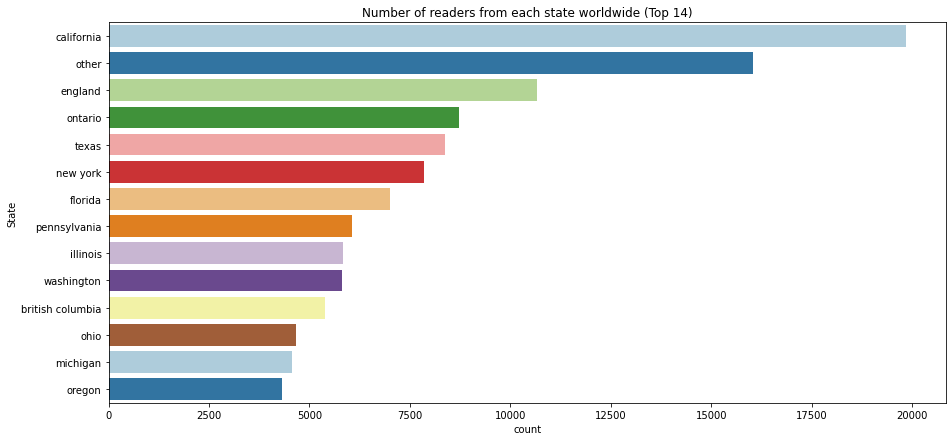

In [58]:
# states with most readers globally
CountPlotN('State',users,14,'Number of readers from each state worldwide (Top 14)')

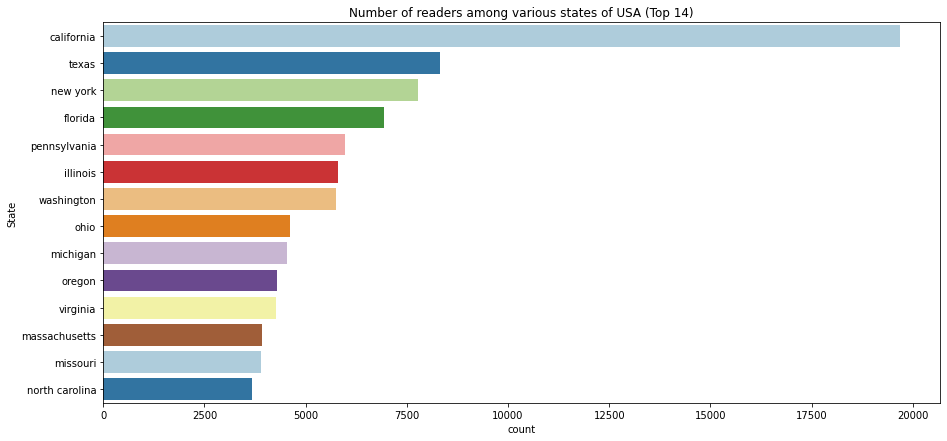

In [59]:
# states with most readers statewise in usa
CountPlotN('State',users[users['Country']=='usa'],14,'Number of readers among various states of USA (Top 14)')

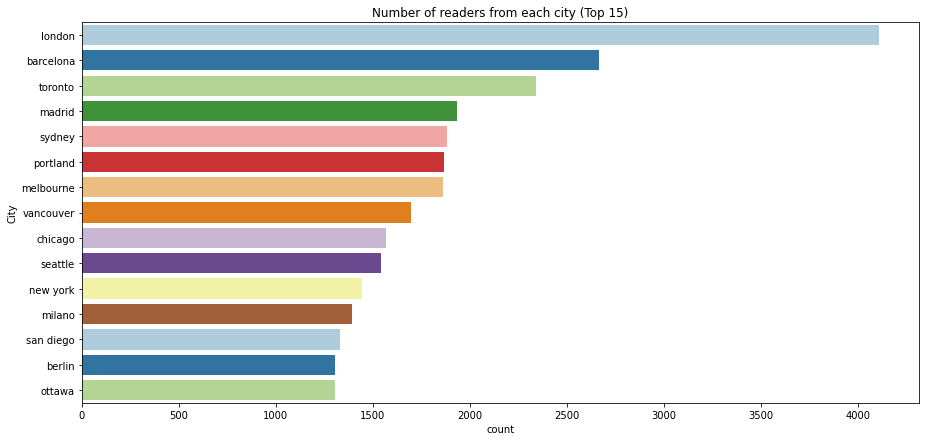

In [60]:
# cities with most readers
CountPlotN('City',users,15,'Number of readers from each city (Top 15)')

# Ratings data cleaning

In [61]:
# look at the ratings data
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [62]:
# info
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [63]:
print(f"Book-ratings Data : {ratings.shape}" )
print(f"Columns: {list(ratings.columns)}" )

Book-ratings Data : (1149780, 3)
Columns: ['User-ID', 'ISBN', 'Book-Rating']


In [64]:
# Checking for null values
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [65]:
# checking User-ID & ratings contains only number or not
print(is_numeric_dtype(ratings['Book-Rating']))
print(is_numeric_dtype(ratings['User-ID']))

True
True


In [66]:
# checking ISBN
specialCharDetector(ratings,'ISBN')

 Special charecters found in ISBN


In [67]:
# remove special chars from isbn in ratings
# removeSpecialChar(ratings)

In [68]:
# Uppercasing all alphabets in ISBN
ratings['ISBN'] = ratings['ISBN'].str.upper()

In [69]:
# Drop duplicate rows
ratings.drop_duplicates(keep='last', inplace=True)
ratings.reset_index(drop=True, inplace=True)

# size of df after dropping
print(f'Shape of dataframe after dropping duplicates : {ratings.shape}')
print(f'Number of duplicates dropped are : {1149760 - ratings.shape[1]}')

Shape of dataframe after dropping duplicates : (1149780, 3)
Number of duplicates dropped are : 1149757


In [70]:
# frequntly used rating value
# CountPlotN('Book-Rating',ratings,14,'most frequnt rating value')

In [71]:
#Hence segragating implicit-0 and explict(~ 0) ratings datasets
non_zero_ratings = ratings[ratings['Book-Rating'] != 0]
zero_rating = ratings[ratings['Book-Rating'] == 0]

In [72]:
# frequntly used rating value
# CountPlotN('Book-Rating',non_zero_ratings,15,'most frequnt rating value excluding zero')

# Merging of all three Tables

Merging Books, Users and Rating Tables in One

In [95]:
dataset = pd.merge(books, ratings, on='ISBN', how='inner')
dataset = pd.merge(dataset, users, on='User-ID', how='inner')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031273 entries, 0 to 1031272
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1031273 non-null  object
 1   Book-Title           1031273 non-null  object
 2   Book-Author          1031272 non-null  object
 3   Year-Of-Publication  1031273 non-null  int64 
 4   Publisher            1031271 non-null  object
 5   User-ID              1031273 non-null  int64 
 6   Book-Rating          1031273 non-null  int64 
 7   Age                  1031273 non-null  int64 
 8   City                 1031273 non-null  object
 9   State                1031273 non-null  object
 10  Country              1031273 non-null  object
dtypes: int64(4), object(7)
memory usage: 94.4+ MB


Divide complete data on the basis of Implicit and Explicit ratings datasets

In [96]:
## Explicit Ratings Dataset
dataset1 = dataset[dataset['Book-Rating'] != 0]
dataset1 = dataset1.reset_index(drop = True)
dataset1.shape

(383892, 11)

In [97]:
## Implicit Ratings Dataset
dataset2 = dataset[dataset['Book-Rating'] == 0]
dataset2 = dataset2.reset_index(drop = True)
dataset2.shape

(647381, 11)

In [98]:
dataset1.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,City,State,Country
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5,35,timmins,ontario,canada
1,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,8,5,35,timmins,ontario,canada
2,0887841740,The Middle Stories,Sheila Heti,2004,House of Anansi Press,8,5,35,timmins,ontario,canada
3,1552041778,Jane Doe,R. J. Kaiser,1999,Mira Books,8,5,35,timmins,ontario,canada
4,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998,Brilliance Audio - Trade,8,6,35,timmins,ontario,canada


# **Data Visualization**

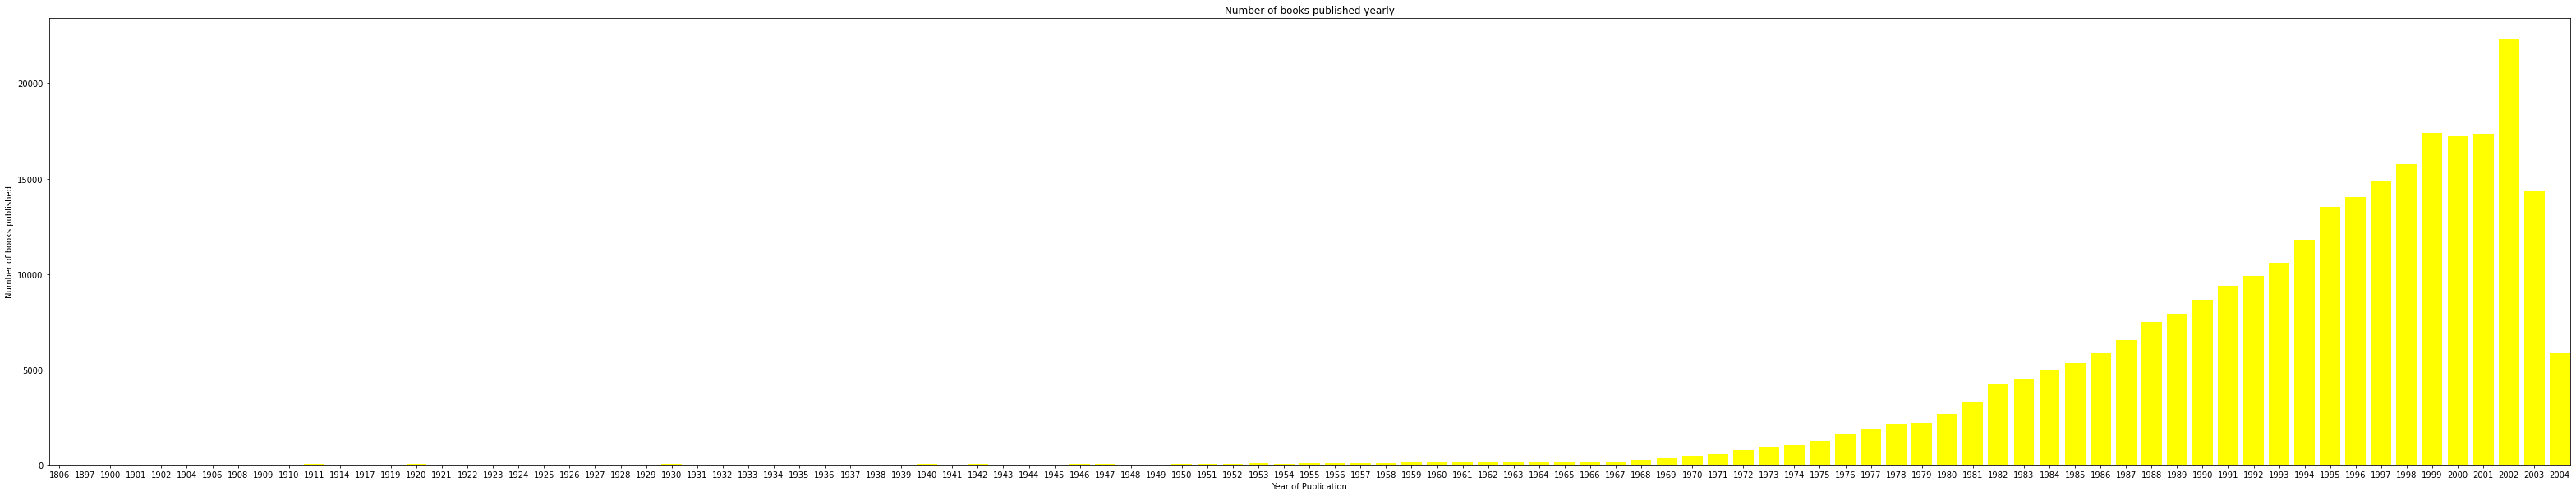

In [101]:
publications = {}
for year in books['Year-Of-Publication']:
    if str(year) not in publications:
        publications[str(year)] = 0
    publications[str(year)] +=1

publications = {k:v for k, v in sorted(publications.items())}

fig = plt.figure(figsize =(55, 10))
plt.bar(list(publications.keys()),list(publications.values()), color = 'yellow')
plt.ylabel("Number of books published")
plt.xlabel("Year of Publication")
plt.title("Number of books published yearly")
plt.margins(x = 0)
plt.show()

Text(0.5, 1.0, 'No of books by an author (Top 13)')

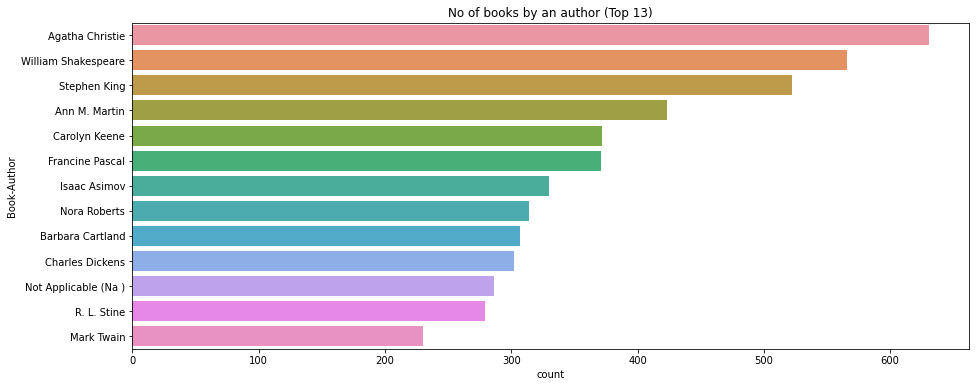

In [102]:
plt.figure(figsize=(15,6))
sns.countplot(y="Book-Author", data=books,order=books['Book-Author'].value_counts().index[0:13])
plt.title("No of books by an author (Top 13)")

Text(0.5, 1.0, 'No of books published by a publisher (Top 13)')

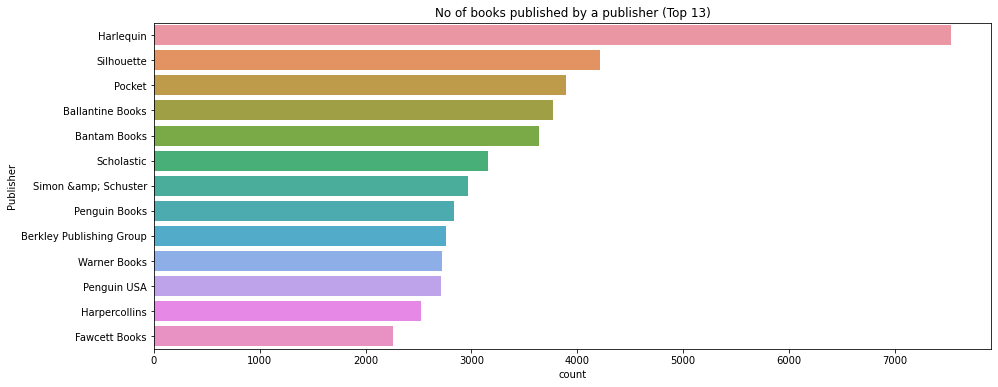

In [103]:
plt.figure(figsize=(15,6))
sns.countplot(y="Publisher", data=books,order=books['Publisher'].value_counts().index[0:13])
plt.title("No of books published by a publisher (Top 13)")

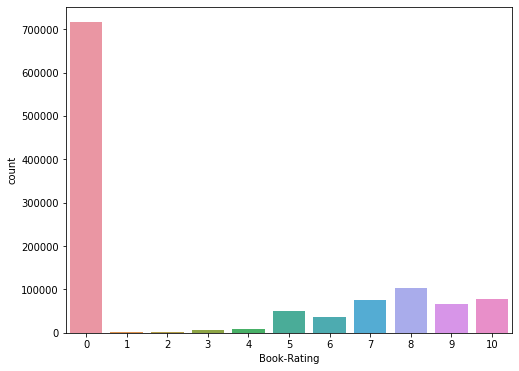

In [104]:
plt.figure(figsize=(8,6))
sns.countplot(x="Book-Rating", data=ratings)

Text(0.5, 1.0, 'Explicit Ratings')

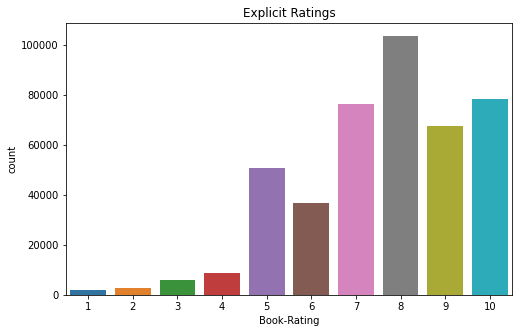

In [106]:
## Explicit Ratings
plt.figure(figsize=(8,5))
data = ratings[ratings['Book-Rating'] != 0]
sns.countplot(x="Book-Rating", data=data)
plt.title("Explicit Ratings")

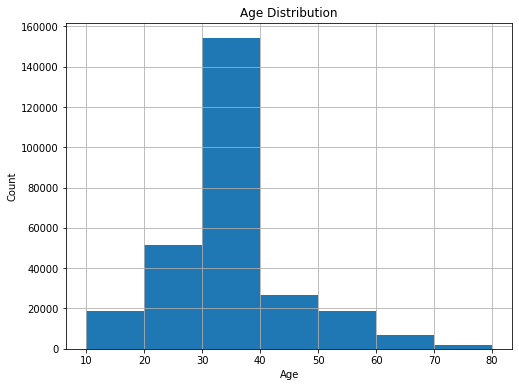

In [107]:
plt.figure(figsize=(8,6))
users.Age.hist(bins=[10*i for i in range(1, 9)])     
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Text(0.5, 1.0, 'No of readers from each city (Top 13)')

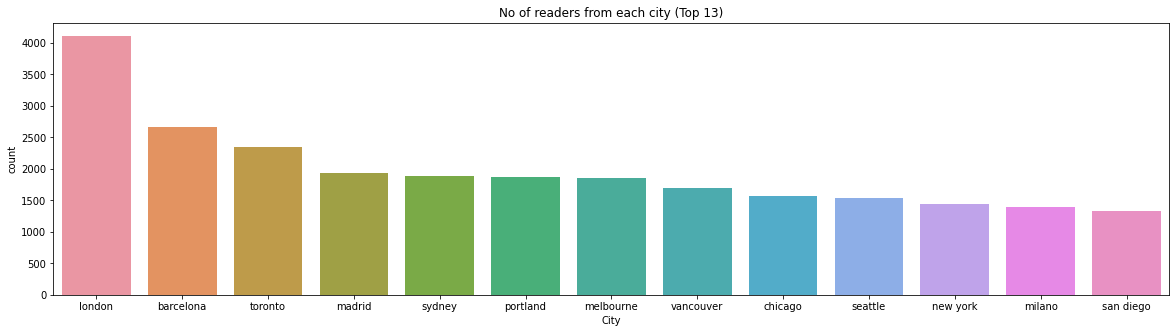

In [108]:
plt.figure(figsize=(20,5))
sns.countplot(x="City", data=users,order=users['City'].value_counts().index[0:13])
plt.title("No of readers from each city (Top 13)")

Text(0.5, 1.0, 'No of readers from each state (Top 13)')

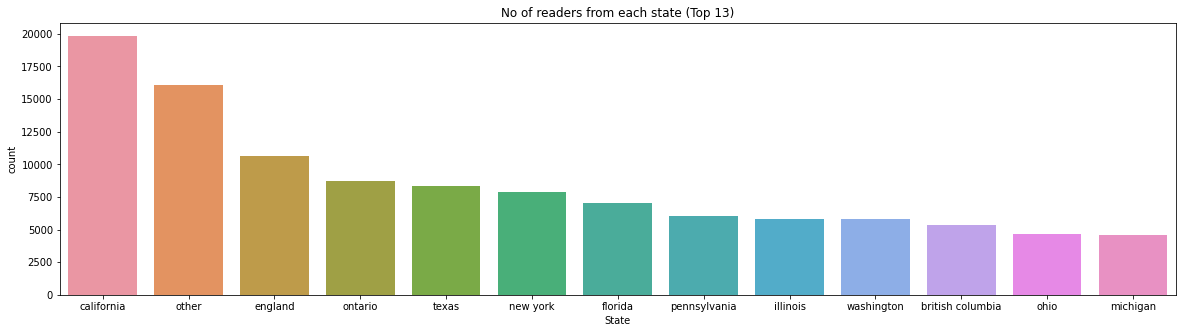

In [109]:
plt.figure(figsize=(20,5))
sns.countplot(x="State", data=users,order=users['State'].value_counts().index[0:13])
plt.title("No of readers from each state (Top 13)")

Text(0.5, 1.0, 'No of readers from each country (Top 10)')

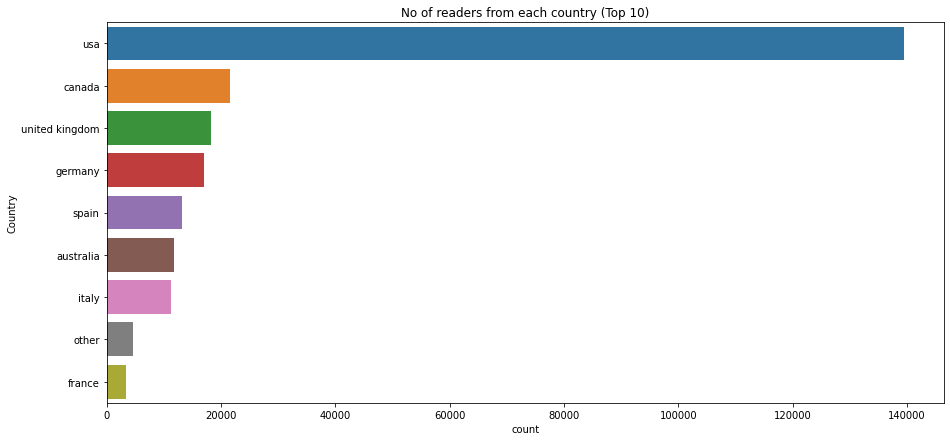

In [110]:
plt.figure(figsize=(15,7))
sns.countplot(y="Country", data=users, order=users['Country'].value_counts().index[0:9])
plt.title("No of readers from each country (Top 10)")

Text(0.5, 1.0, 'No of readers from states of USA (Top 15)')

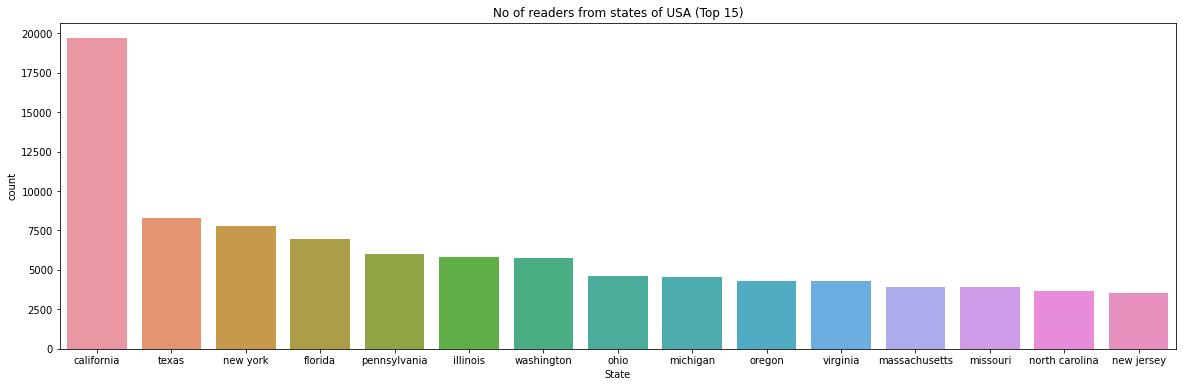

In [111]:
data=users[users['Country']=='usa']
plt.figure(figsize=(20,6))
sns.countplot(x="State", data=data,order=data['State'].value_counts().index[0:15])
plt.title("No of readers from states of USA (Top 15)")

Text(0.5, 1.0, 'Number of Ratings for a book (Top 15)')

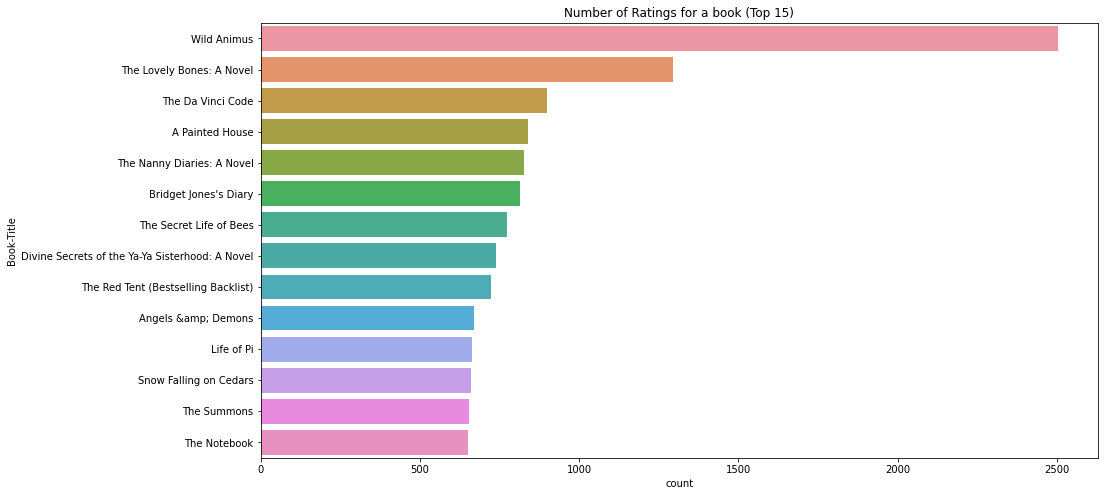

In [112]:
plt.figure(figsize=(15,8))
sns.countplot(y="Book-Title", data=dataset, order=dataset['Book-Title'].value_counts().index[0:14])
plt.title("Number of Ratings for a book (Top 15)")

# Recommender Systems

# 1. Books by same author, publisher of given book name

In [121]:
# print books of a dataframe
def printBook(k, n):
  ''' a function that prints n required books
      k - dataframe,
      n - number of top n elements '''
  # get a set of names of books present in the df(k)
  z = k['Book-Title'].unique()
  # loop through book titles and print them
  for x in range(len(z)):
        print(z[x])
        if x >= n-1:
            break

In [122]:
# get books suggestions of pirticular author or publisher
def getBooks(dataframe, name, n, col_name):
  ''' taking a dataframe as input,name= bookname, 
      n = number of top n elements required,
      col_name = columns_name of author or publisher '''

  print(f"\nBooks by same {col_name}:\n")
  # a list of all authors/publishers for requested books
  name_list = dataframe[col_name].unique()
  # print('1')
  # exclude the requested book from suggestions
  data = df[df['Book-Title'] != name]
  # print('2')          
  # check if author/publisher name is in the dataframe
  if name_list[0] in data[col_name].unique(): 
    # a df(k) that contain books of chosen author/publisher
    k = data[data[col_name] == name_list[0]]
  # sort and print the df(k)
  k = k.sort_values(by=['Book-Rating'])
  printBook(k, n)

In [123]:
bookName = " Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))" #input("Enter a book name: ")
# ex - Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

# check if book exists in the set of book-titles
if bookName in list(df['Book-Title'].unique()):
    # send a df of the requested book
    d = df[df['Book-Title'] == bookName]
    # loop the function and print out publishers and authors
    for col_name in ['Book-Author', 'Publisher']:
      getBooks(d, bookName, recomm_number, col_name)
      print('-'*30)
else:
    # in case the requested book does not exist in the dataset
    print("Oops!! the requested book does not seem to be present ")

Oops!! the requested book does not seem to be present 


# 2 Books by Average Weighted Ratings






In the above cases we have seen models that rank books on either the number of readers or the most rated ones this model is an extension of that to ensure that instead of soley relying on one we can use the weighted average concept to make a better model

In [125]:
# create a copy of df(average rating df)
avg_r_df = df.copy()
# calculate the average ratings
avg_r_df['Average Rating']=df.groupby('ISBN')['Book-Rating'].transform('mean')
# calculate the total ratings given every book
avg_r_df['Total-Ratings']=avg_r_df.groupby('ISBN')['Book-Rating'].transform('count')
# show average-rating-dataframe
avg_r_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,City,State,Country,Average Rating,Total-Ratings
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5,35,timmins,ontario,canada,7.666667,9
1,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,8,5,35,timmins,ontario,canada,5.000000,1
2,0887841740,The Middle Stories,Sheila Heti,2004,House of Anansi Press,8,5,35,timmins,ontario,canada,5.000000,1
3,1552041778,Jane Doe,R. J. Kaiser,1999,Mira Books,8,5,35,timmins,ontario,canada,5.000000,1
4,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998,Brilliance Audio - Trade,8,6,35,timmins,ontario,canada,6.000000,1


In [126]:
# mean_ratin - Mean vote across the whole
mean_ratin = avg_r_df['Average Rating'].mean()

# Minimum number of votes required to be in the chart
# choose the top 90 percentile of the data
m = avg_r_df['Total-Ratings'].quantile(0.90)
print(f'C={mean_ratin} , m={m}')

# choosing total ratings in dataset greater than the 90th percentile
avg_r_90_percent = avg_r_df.loc[avg_r_df['Total-Ratings'] >= m]
# print the average-rating-dataframe 90th percentile
print(f'The data shape of average ratings df before slicinng based on 90 percentile {avg_r_df.shape} after slicing {avg_r_90_percent.shape}')

C=7.626762214372794 , m=65.0
The data shape of average ratings df before slicinng based on 90 percentile (383892, 13) after slicing (38502, 13)


In [127]:
# calc the weighted average of books 
def weightedRating(x, m=m, C=mean_ratin): 
    ''' returns weighted avarage of items, taken is x = dataframe,
        m = top 90 percentile data, c = mean-rating of the dataset'''
    #  v - number of votes
    v = x['Total-Ratings'] 
    # R - Average Rating     
    R = x['Average Rating']   
    return (v/(v+m) * R) + (m/(m+v) * C)

In [128]:
# calc score(weighted_average)
avg_r_90_percent['Score'] = avg_r_90_percent.apply(weightedRating, axis=1)
# sort based on the best ones(highest-weighted-avg)
avgwr_df = avg_r_90_percent.drop_duplicates('ISBN').sort_index()
#Sorting books based on score calculated above
avgwr_df = avgwr_df.sort_values('Score', ascending=False)
recomm_number =5
print("Book recommendation based of on Weighted Average ratings :-\n")
# choose the required nummber of books
avgwr_df[['Book-Title', 'Total-Ratings', 'Average Rating', 'Score']].reset_index(drop=True).head(recomm_number)

# avgwr_df.shape

Book recommendation based of on Weighted Average ratings :-



,Book-Title,Total-Ratings,Average Rating,Score
0,Harry Potter and the Goblet of Fire (Book 4),137,9.262774,8.736334
1,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),315,8.936508,8.712472
2,Harry Potter and the Order of the Phoenix (Book 5),207,9.038647,8.701248
3,To Kill a Mockingbird,214,8.943925,8.637059
4,Harry Potter and the Prisoner of Azkaban (Book 3),133,9.082707,8.604745


# 3. Collaborative Filtering (User-Item Filtering)

Selecting books with total ratings equals to or more than 50 (Because of availability of limited resources)

In [130]:
df = pd.DataFrame(dataset1['Book-Title'].value_counts())
df['Total-Ratings'] = df['Book-Title']
df['Book-Title'] = df.index
df.reset_index(level=0, inplace=True)
df = df.drop('index',axis=1)

df = dataset1.merge(df, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
df = df.drop(['Year-Of-Publication','Publisher','Age','City','State','Country'], axis=1)

popularity_threshold = 50
popular_book = df[df['Total-Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)

In [131]:
testdf = pd.DataFrame()
testdf['ISBN'] = popular_book['ISBN']
testdf['Book-Rating'] = popular_book['Book-Rating']
testdf['User-ID'] = popular_book['User-ID']
testdf = testdf[['User-ID','Book-Rating']].groupby(testdf['ISBN'])

In [132]:
listOfDictonaries=[]
indexMap = {}
reverseIndexMap = {}
ptr=0

for groupKey in testdf.groups.keys():
    tempDict={}
    groupDF = testdf.get_group(groupKey)
    for i in range(0,len(groupDF)):
        tempDict[groupDF.iloc[i,0]] = groupDF.iloc[i,1]
    indexMap[ptr]=groupKey
    reverseIndexMap[groupKey] = ptr
    ptr=ptr+1
    listOfDictonaries.append(tempDict)

dictVectorizer = DictVectorizer(sparse=True)
vector = dictVectorizer.fit_transform(listOfDictonaries)
pairwiseSimilarity = cosine_similarity(vector)

In [133]:
def printBookDetails(bookID):
    print(dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])
    """
    print("Title:", dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])
    print("Author:",dataset1[dataset['ISBN']==bookID]['Book-Author'].values[0])
    #print("Printing Book-ID:",bookID)
    print("\n")
    """

def getTopRecommandations(bookID):
    collaborative = []
    row = reverseIndexMap[bookID]
    print("Input Book:")
    printBookDetails(bookID)
    
    print("\nRECOMMENDATIONS:\n")
    
    mn = 0
    similar = []
    for i in np.argsort(pairwiseSimilarity[row])[:-2][::-1]:
          if dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0] not in similar:
                if mn>=number:
                      break
                mn+=1
                similar.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
                printBookDetails(indexMap[i])
                collaborative.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
    return collaborative


# Conclusion

1.In EDA, the Top-10 most rated books were essentially novels. Books like The Lovely Bone and Wild Animus were very well perceived

2.Majority of the readers were of the age bracket 20-40 and most of them came from North American and European countries namely USA, Canada, UK, Germany and Spain.

3.If we look at the ratings distribution, most of the books have high ratings with maximum books being rated 8. Ratings below 5 are few in number.
Author with the most books was Agatha Christie, William Shakespeare and Stephen King.

4.Amongst the memory based approach, User-item CF performed because of lower computation .